In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


**Prepare & Handle Data**

In [ ]:
df = pd.read_csv('sp500_dataset.csv')

In [ ]:
df.head()

,Unnamed: 0,DATE,15dH,15dL,15dC,15dV,OBV,Date_N,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP,NFCI,Close
0,1,1982-02,119.809998,112.820000,115.773000,482290000,12663310000,-38.916667,6.197611,7.623742,94.4,13.22,8.6,3274.302000,1.94193,113.110001
1,2,1982-03,114.800003,104.459999,109.920908,677580000,11985730000,-38.833333,6.079232,7.656648,94.7,14.78,8.9,3293.525333,2.09219,111.959999
2,3,1982-04,117.120003,111.480003,115.485001,506350000,12492080000,-38.750000,5.648130,7.128993,94.7,14.68,9.0,3312.748667,2.17164,116.440002
3,4,1982-05,119.919998,115.910004,118.330000,567060000,13059140000,-38.666667,5.713188,7.408347,95.0,14.94,9.3,3331.972000,2.38438,111.879997
4,5,1982-06,112.480003,108.529999,110.446363,535280000,12523860000,-38.583333,5.689980,7.320041,95.9,14.45,9.4,3343.422000,2.80708,109.610001


In [ ]:
X = df.iloc[:,2:-1]
y = df.iloc[:,-1:]
X.head()

,15dH,15dL,15dC,15dV,OBV,Date_N,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP,NFCI
0,119.809998,112.820000,115.773000,482290000,12663310000,-38.916667,6.197611,7.623742,94.4,13.22,8.6,3274.302000,1.94193
1,114.800003,104.459999,109.920908,677580000,11985730000,-38.833333,6.079232,7.656648,94.7,14.78,8.9,3293.525333,2.09219
2,117.120003,111.480003,115.485001,506350000,12492080000,-38.750000,5.648130,7.128993,94.7,14.68,9.0,3312.748667,2.17164
3,119.919998,115.910004,118.330000,567060000,13059140000,-38.666667,5.713188,7.408347,95.0,14.94,9.3,3331.972000,2.38438
4,112.480003,108.529999,110.446363,535280000,12523860000,-38.583333,5.689980,7.320041,95.9,14.45,9.4,3343.422000,2.80708


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)


**Linear Model Feature Selection**

In [ ]:
mse_list1=[]
pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
for i in range(3):
  y_pred = cross_val_predict(pipe1, X.iloc[:,i].to_frame(), y, cv=kf)
  mse_list1.append(mean_squared_error(y, y_pred))
mse_list1

[5086.358063749962, 5276.096715720568, 4437.53413038825]

In [ ]:
#15dC shows the min mse and thus is reserved for the linear model
pipe1.fit(X['15dC'].to_frame(),y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

**Polynomial Model Feature & Degree Selection**

In [ ]:
!pip install scikit-optimize
!pip install 'scikit-optimize[plots]'
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from skopt.space import Real, Categorical, Integer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(include_bias=True)),
    ('regressor', LinearRegression())
])
param_grid = {'poly_features__degree': [1, 2, 3, 4, 5]}
grid1 = GridSearchCV(pipe2, param_grid, cv=kf, scoring='neg_mean_squared_error')
best_list2=[]
for i in range(3):
  grid1.fit(X.iloc[:,(i*3)+5].to_frame(), y)
  degree = grid1.best_params_
  best_score = -grid1.best_score_
  best_list2.append([degree,best_score])

In [ ]:
best_list2

[[{'poly_features__degree': 5}, 44007.752286518014],
 [{'poly_features__degree': 5}, 84153.00366408654],
 [{'poly_features__degree': 4}, 61090.94761483901]]

In [ ]:
#Date_N with degree=5 has the best performance among the 3 yet still terrible. let's try to compare it with all 3 together.
grid1.fit(X.iloc[:,np.r_[5,8,11]], y)
[grid1.best_params_, -grid1.best_score_]

[{'poly_features__degree': 4}, 13507.68856734389]

In [ ]:
#Using all the 3 features yield much better result. Let's compare it to OBV alone though.
grid1.fit(X.iloc[:, 4].to_frame(), y)
[grid1.best_params_, -grid1.best_score_]

[{'poly_features__degree': 5}, 21510.90978167765]

In [ ]:
#Let's try to use all 4 features
grid1.fit(X.iloc[:, np.r_[4,5,8,11]], y)
[grid1.best_params_, -grid1.best_score_]

[{'poly_features__degree': 4}, 15836.0166011908]

In [ ]:
X[['Date_N','CPIAUCSL','GDP']].shape

(512, 3)

In [ ]:
y.shape

(512, 1)

In [ ]:
#Using Date_N, CPIAUCSL, and GDP only with degree=4 yield the min mse and thus is reserved for the polynomial model
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=4)),
    ('regressor', LinearRegression())
])
pipe2.fit(X.iloc[:,np.r_[5,8,11]],y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_features', PolynomialFeatures(degree=4)),
                ('regressor', LinearRegression())])

**XGBoost Model Feature Selection**

In [ ]:
import xgboost as xgb
pipe3 = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=1))
])

y_pred = cross_val_predict(pipe3, X, y, cv=kf)
mse = mean_squared_error(y, y_pred, squared=True)
mse

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7206.795603635749

In [ ]:
#XGBoost with all features and the defaulted params yield a pretty good result. Let's see if we can improve it by reducing some features

In [ ]:
#Method 1: Backward Elimination

pipe3.fit(X,y) #this step is to extract the feature importance, not for evaluation. so it is fine to include the whole dataset.

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=1, ...))])

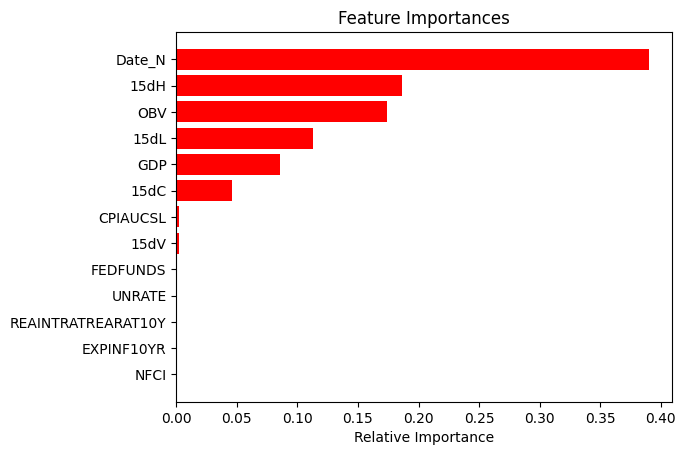

In [ ]:
xgb0 = pipe3.named_steps['reg']

# Get feature importance
feature_importance = xgb0.get_booster().get_score(importance_type='gain')
importances = xgb0.feature_importances_
features = X.columns
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
XGBX = X[['Date_N','15dH','OBV','15dL','GDP','15dC','CPIAUCSL']]
XGBX.head()

,Date_N,15dH,OBV,15dL,GDP,15dC,CPIAUCSL
0,-38.916667,119.809998,12663310000,112.820000,3274.302000,115.773000,94.4
1,-38.833333,114.800003,11985730000,104.459999,3293.525333,109.920908,94.7
2,-38.750000,117.120003,12492080000,111.480003,3312.748667,115.485001,94.7
3,-38.666667,119.919998,13059140000,115.910004,3331.972000,118.330000,95.0
4,-38.583333,112.480003,12523860000,108.529999,3343.422000,110.446363,95.9


In [ ]:
mse_list3=[]
for i in range(5):
  y_pred = cross_val_predict(pipe3, XGBX.iloc[:,:-1-i], y, cv=kf)
  mse = mean_squared_error(y, y_pred, squared=True)
  mse_list3.append(mse)
y_pred = cross_val_predict(pipe3, XGBX.iloc[:,0].to_frame(), y, cv=kf)
mse_list3.append(mean_squared_error(y, y_pred, squared=True))
mse_list3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

[7637.358492483434,
 7806.682267339268,
 7474.2167545898155,
 8758.681455149974,
 7708.772595784233,
 7027.184508485961]

In [ ]:
#It is found that having Date_N alone yield the best result. Let's try another approach, i.e. recursive feature elimination, and see if it can enhance the performance

In [ ]:
from sklearn.feature_selection import RFE
best_list4 = []
for i in range(12):
  rfe = RFE(estimator=xgb0, n_features_to_select=i+2, step=1)
  pipe4 = Pipeline([
      ('scaler', StandardScaler()),
      ('feature_selection', rfe),
      ('reg', xgb0)
  ])

  pipe4.fit(X, y)

  selected_features = rfe.support_
  feature_ranking = rfe.ranking_
  y_pred = cross_val_predict(pipe4, X.iloc[:,selected_features], y, cv=kf)
  mse = mean_squared_error(y, y_pred, squared=True)

  best_list4.append([selected_features,mse])
best_list4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

[[array([ True, False, False, False, False,  True, False, False, False,
         False, False, False, False]),
  8101.721591828847],
 [array([ True, False, False, False,  True,  True, False, False, False,
         False, False, False, False]),
  8890.21528772554],
 [array([ True,  True, False, False,  True,  True, False, False, False,
         False, False, False, False]),
  7789.583379272847],
 [array([ True,  True,  True, False,  True,  True, False, False, False,
         False, False, False, False]),
  7474.831751389289],
 [array([ True,  True,  True, False,  True,  True, False, False, False,
         False, False,  True, False]),
  7675.243682066028],
 [array([ True,  True,  True,  True,  True,  True, False, False, False,
         False, False,  True, False]),
  7522.394240733179],
 [array([ True,  True,  True,  True,  True,  True, False, False,  True,
         False, False,  True, False]),
  7485.488891157064],
 [array([ True,  True,  True,  True,  True,  True,  True, False,  True

In [ ]:
#It is found that the dataset without UNRATE and NFCI yields the best result, even better than Date_N alone
XGBX2 = X.drop(['UNRATE','NFCI'], axis=1)
XGBX2.head()

,15dH,15dL,15dC,15dV,OBV,Date_N,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,GDP
0,119.809998,112.820000,115.773000,482290000,12663310000,-38.916667,6.197611,7.623742,94.4,13.22,3274.302000
1,114.800003,104.459999,109.920908,677580000,11985730000,-38.833333,6.079232,7.656648,94.7,14.78,3293.525333
2,117.120003,111.480003,115.485001,506350000,12492080000,-38.750000,5.648130,7.128993,94.7,14.68,3312.748667
3,119.919998,115.910004,118.330000,567060000,13059140000,-38.666667,5.713188,7.408347,95.0,14.94,3331.972000
4,112.480003,108.529999,110.446363,535280000,12523860000,-38.583333,5.689980,7.320041,95.9,14.45,3343.422000


**XGBoost Model Parameter Tuning**

In [ ]:
 #Bayesian search for initial tuning
 search_space = {
    'reg__n_estimators': Integer(50, 100),
    'reg__max_depth': Integer(3,10),
    'reg__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'reg__min_child_weight': Integer(1, 10),
    'reg__subsample': Real(0.5, 1.0),
    'reg__colsample_bytree': Real(0.5, 1.0),
    'reg__colsample_bylevel': Real(0.5, 1.0),
    'reg__colsample_bynode' : Real(0.5, 1.0),
    'reg__alpha': Real(0.0, 10.0),
    'reg__lambda': Real(0.0, 10.0),
    'reg__gamma': Real(0.0, 5.0)
}

bayexgb = BayesSearchCV(pipe3, search_space, cv=3, n_iter=100, scoring='neg_mean_squared_error', random_state=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(XGBX2,y,random_state=1)
bayexgb.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('reg',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='rmse',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=...
                             'reg__learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='normalize'),
                             'reg__max_depth': Integer(low=3, high=10, prior='uniform', transform='normalize'),
                             'reg__min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'reg__n_estimators': Integer(low=50, high=100, prior='uniform', transform='normalize'),
                             'reg__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [ ]:
bayexgb = bayexgb.best_estimator_
bayexgb

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 XGBRegressor(alpha=1.0344071203938863, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=0.5675025901504364,
                              colsample_bynode=1.0, colsample_bytree=1.0,
                              device=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=5.0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, lambda=0.0,
                              learning_rate=0.11339675048149077, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None, ...))])

In [ ]:
params = bayexgb.get_params()
for param, value in params.items():
    print(f"{param}: {value}")

memory: None
steps: [('scaler', StandardScaler()), ('reg', XGBRegressor(alpha=1.0344071203938863, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=0.5675025901504364,
             colsample_bynode=1.0, colsample_bytree=1.0, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=5.0,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.0,
             learning_rate=0.11339675048149077, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, ...))]
verbose: False
scaler: StandardScaler()
reg: XGBRegressor(alpha=1.0344071203938863, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=0

In [ ]:
#Since the model has seen 75% of the data. there is no point to do cross-validation at this state)
baye_y_pred = bayexgb.predict(X_test)
mean_squared_error(y_test, baye_y_pred)

6697.279267389626

In [ ]:
paramg={
    'reg__n_estimators': [99, 100, 101],
    'reg__max_depth': [2,3,4],
    'reg__learning_rate': [0.11339675048149077, 0.11, 0.1168],
    'reg__gamma': [5, 4.9, 5.1],
    'reg__lambda': [0, 0.001, 0.002],
    'reg__alpha': [1.0344071203938863, 1.03, 1.0388]
}

gridxgb = GridSearchCV(estimator=bayexgb, param_grid=paramg, cv=3, scoring='neg_mean_squared_error')

In [ ]:
gridxgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg',
                                        XGBRegressor(alpha=1.0344071203938863,
                                                     base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=0.5675025901504364,
                                                     colsample_bynode=1.0,
                                                     colsample_bytree=1.0,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric='rmse',
                                                     feature_types=None,
                                                     gamma=5....
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=100,
                                                     n_jobs=None, ...))]),
             param_grid={'reg__alpha': [1.0344071203938863, 1.03, 1.0388],
                         'reg__gamma': [5, 4.9, 5.1],
                         'reg__lambda': [0, 0.001, 0.002],
                         'reg__learning_rate': [0.11339675048149077, 0.11,
                                                0.1168],
                         'reg__max_depth': [2, 3, 4],
                         'reg__n_estimators': [99, 100, 101]},
             scoring='neg_mean_squared_error')

In [ ]:
gridxgb = gridxgb.best_estimator_
gridxgb

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 XGBRegressor(alpha=1.0388, base_score=None, booster=None,
                              callbacks=None,
                              colsample_bylevel=0.5675025901504364,
                              colsample_bynode=1.0, colsample_bytree=1.0,
                              device=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=5, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, lambda=0.001,
                              learning_rate=0.11339675048149077, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=101, n_jobs=None, ...))])

In [ ]:
grid_y_pred = gridxgb.predict(X_test)
mean_squared_error(y_test, grid_y_pred)

6003.87884515615

In [ ]:
gridxgb.fit(XGBX2,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 XGBRegressor(alpha=1.0388, base_score=None, booster=None,
                              callbacks=None,
                              colsample_bylevel=0.5675025901504364,
                              colsample_bynode=1.0, colsample_bytree=1.0,
                              device=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=5, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, lambda=0.001,
                              learning_rate=0.11339675048149077, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=101, n_jobs=None, ...))])

In [ ]:
lin_reg = pipe1
poly_reg = pipe2
xgb_reg = gridxgb

In [ ]:
lin_pred = cross_val_predict(lin_reg, X[['15dC']], y, cv=kf).ravel()
poly_pred = cross_val_predict(poly_reg, X.iloc[:, np.r_[5,8,11]], y, cv=kf).ravel()
xgb_pred = cross_val_predict(xgb_reg, XGBX2, y, cv=kf).ravel()

In [ ]:
meta_features = pd.DataFrame({
    'lin_pred': lin_pred,
    'poly_pred': poly_pred,
    'xgb_pred': xgb_pred
})

# Train the meta-model
meta_model = LinearRegression()
meta_model.fit(meta_features, y)

LinearRegression()

In [ ]:
meta_pred = cross_val_predict(meta_model, meta_features, y, cv=kf)

# Evaluate the meta-model
meta_mse = mean_squared_error(y, meta_pred)
print(f'Meta-model MSE: {meta_mse}')

# Compare with individual models
lin_mse = mean_squared_error(y, lin_pred)
poly_mse = mean_squared_error(y, poly_pred)
xgb_mse = mean_squared_error(y, xgb_pred)

print(f'Linear model MSE: {lin_mse}')
print(f'Polynomial model MSE: {poly_mse}')
print(f'XGBoost model MSE: {xgb_mse}')

Meta-model MSE: 4340.010348312069
Linear model MSE: 4437.53413038825
Polynomial model MSE: 13497.705237224758
XGBoost model MSE: 6299.236846075746


In [ ]:
import joblib
joblib.dump(meta_model,'/content/drive/My Drive/Colab Notebooks/meta_model.pkl')
joblib.dump(lin_reg,'/content/drive/My Drive/Colab Notebooks/lin_reg.pkl')
joblib.dump(poly_reg,'/content/drive/My Drive/Colab Notebooks/poly_reg.pkl')
joblib.dump(xgb_reg, '/content/drive/My Drive/Colab Notebooks/xgb_reg.pkl')

['/content/drive/My Drive/Colab Notebooks/xgb_reg.pkl']